In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parquet',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': []}

In [3]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Lets load the data

In [4]:
df = pd.read_parquet(datafile)
df

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length
0,2023-02-01 19:59:48+00:00,"Dank voor bericht, Marijke",kooky-tapir,False,False,26,False,evening,19:59:48,2,26
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,2,87
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,2,31
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,2,40
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,2,19
...,...,...,...,...,...,...,...,...,...,...,...
4560,2025-09-09 08:39:49+00:00,Het zijn geen kleine kuikentjes meer!!🦢🐣🥰,dazzling-yak,True,False,41,False,worktimes,08:39:49,1,41
4561,2025-09-09 08:41:03+00:00,😍,flexible-platypus,True,True,1,False,worktimes,08:41:03,1,1
4562,2025-09-09 08:54:40+00:00,👍,nimble-raven,True,False,1,False,worktimes,08:54:40,1,1
4563,2025-09-09 12:34:38+00:00,Morgen gedurende de dag zijn er mensen op het ...,intense-toad,False,True,300,False,worktimes,12:34:38,1,300


Let's extract some more info from the timestamp:

In [5]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df["year-week"] = df["timestamp"].dt.strftime("%Y-%W")
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,date,isoweek,year-week
0,2023-02-01 19:59:48+00:00,"Dank voor bericht, Marijke",kooky-tapir,False,False,26,False,evening,19:59:48,2,26,2023-02-01,5,2023-05
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,2,87,2023-02-01,5,2023-05
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,2,31,2023-02-01,5,2023-05
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,2,40,2023-02-01,5,2023-05
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,2,19,2023-02-01,5,2023-05


In [6]:
topk = list(df[df["is_topk"]].author.unique())
topk

['intense-toad',
 'eye-catching-hare',
 'cackling-eland',
 'vivid-rhinoceros',
 'sudsy-jellyfish',
 'carefree-lark',
 'snorting-ibex',
 'cheerful-mule',
 'zany-trout',
 'sudsy-eland',
 'springy-hare',
 'flexible-platypus',
 'limber-ostrich',
 'silky-lapwing',
 'radiant-coyote']

Now, we can group by the isoweeks, for example. 
Let's reindex in order to fill the missing weeks.

In [7]:
df = df.drop(index=[0])

In [8]:
p = df.groupby("year-week").count()
p.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,date,isoweek
year-week,,,,,,,,,,,,,
2023-05,11,11,11,11,11,11,11,11,11,11,11,11,11
2023-06,8,8,8,8,8,8,8,8,8,8,8,8,8
2023-07,28,28,28,28,28,28,28,28,28,28,28,28,28
2023-08,2,2,2,2,2,2,2,2,2,2,2,2,2
2023-09,16,16,16,16,16,16,16,16,16,16,16,16,16


In [9]:
min_ts = df["timestamp"].min()
max_ts = df["timestamp"].max()
new_index = pd.date_range(
    start=min_ts, end=max_ts, freq="W", name="year-week"
).strftime("%Y-%W")
p = p.reindex(new_index, fill_value=0)
p.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,date,isoweek
year-week,,,,,,,,,,,,,
2023-05,11,11,11,11,11,11,11,11,11,11,11,11,11
2023-06,8,8,8,8,8,8,8,8,8,8,8,8,8
2023-07,28,28,28,28,28,28,28,28,28,28,28,28,28
2023-08,2,2,2,2,2,2,2,2,2,2,2,2,2
2023-09,16,16,16,16,16,16,16,16,16,16,16,16,16


Text(0.5, 1.0, 'Messages over time')

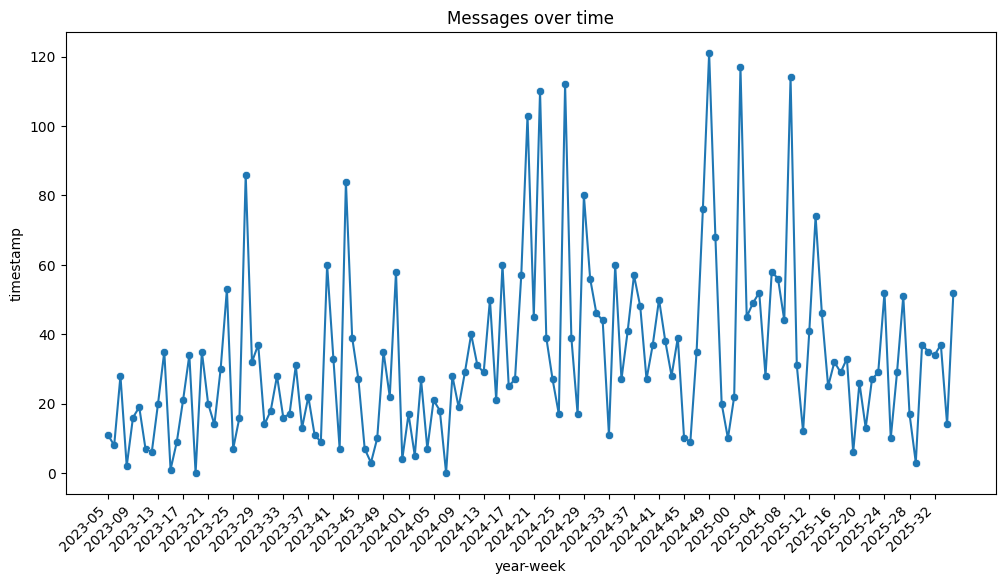

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=p, x=p.index, y="timestamp", ax=ax)
p["moving_avg"] = p["timestamp"].rolling(window=1).mean()
sns.lineplot(data=p, x=p.index, y="moving_avg", ax=ax)

interval = 4
xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha="right")
plt.title("Messages over time")

Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors.
Probaly, a scatterplot and lineplot are not the best way to show the count of messages per author, per week, for your data, so you might need to modify that. It might not even be useful for your data to do this (eg because you have too many authors).

The main goal here is to find some way to visualise the count over time, per author, and to give you some starting point if that is relevant for your dataset.

In [11]:
# keep only topk authors

p = df[df["author"].isin(topk)].groupby(["author", "year-week"]).count()
# p = df.groupby(["author", "year-week"]).count()
p

timestamp  message  has_emoji  is_topk  \
author         year-week                                           
cackling-eland 2023-06            1        1          1        1   
               2023-14            5        5          5        5   
               2023-18            1        1          1        1   
               2023-20            5        5          5        5   
               2023-21            2        2          2        2   
...                             ...      ...        ...      ...   
zany-trout     2025-31            7        7          7        7   
               2025-32            2        2          2        2   
               2025-33            1        1          1        1   
               2025-34            2        2          2        2   
               2025-35            6        6          6        6   

                          message_length  has_link  timestamp_category  hour  \
author         year-week                                                       
cackling-eland 2023-06                 1         1                   1     1   
               2023-14                 5         5                   5     5   
               2023-18                 1         1                   1     1   
               2023-20                 5         5                   5     5   
               2023-21                 2         2                   2     2   
...                                  ...       ...                 ...   ...   
zany-trout     2025-31                 7         7                   7     7   
               2025-32                 2         2                   2     2   
               2025-33                 1         1                   1     1   
               2025-34                 2         2                   2     2   
               2025-35                 6         6                   6     6   

                          day_of_week  msg_length  date  isoweek  
author         year-week                                          
cackling-eland 2023-06              1           1     1        1  
               2023-14              5           5     5        5  
               2023-18              1           1     1        1  
               2023-20              5           5     5        5  
               2023-21              2           2     2        2  
...                               ...         ...   ...      ...  
zany-trout     2025-31              7           7     7        7  
               2025-32              2           2     2        2  
               2025-33              1           1     1        1  
               2025-34              2           2     2        2  
               2025-35              6           6     6        6  

[1020 rows x 12 columns]

In [12]:
# authors = df["author"].unique()
multi_index = pd.MultiIndex.from_product(
    [topk, new_index], names=["author", "year-week"]
)
p = p.reindex(multi_index, fill_value=0)
p

timestamp  message  has_emoji  is_topk  \
author         year-week                                           
intense-toad   2023-05            5        5          5        5   
               2023-06            1        1          1        1   
               2023-07            2        2          2        2   
               2023-08            0        0          0        0   
               2023-09            0        0          0        0   
...                             ...      ...        ...      ...   
radiant-coyote 2025-31            0        0          0        0   
               2025-32            1        1          1        1   
               2025-33            1        1          1        1   
               2025-34            0        0          0        0   
               2025-35            3        3          3        3   

                          message_length  has_link  timestamp_category  hour  \
author         year-week                                                       
intense-toad   2023-05                 5         5                   5     5   
               2023-06                 1         1                   1     1   
               2023-07                 2         2                   2     2   
               2023-08                 0         0                   0     0   
               2023-09                 0         0                   0     0   
...                                  ...       ...                 ...   ...   
radiant-coyote 2025-31                 0         0                   0     0   
               2025-32                 1         1                   1     1   
               2025-33                 1         1                   1     1   
               2025-34                 0         0                   0     0   
               2025-35                 3         3                   3     3   

                          day_of_week  msg_length  date  isoweek  
author         year-week                                          
intense-toad   2023-05              5           5     5        5  
               2023-06              1           1     1        1  
               2023-07              2           2     2        2  
               2023-08              0           0     0        0  
               2023-09              0           0     0        0  
...                               ...         ...   ...      ...  
radiant-coyote 2025-31              0           0     0        0  
               2025-32              1           1     1        1  
               2025-33              1           1     1        1  
               2025-34              0           0     0        0  
               2025-35              3           3     3        3  

[2040 rows x 12 columns]

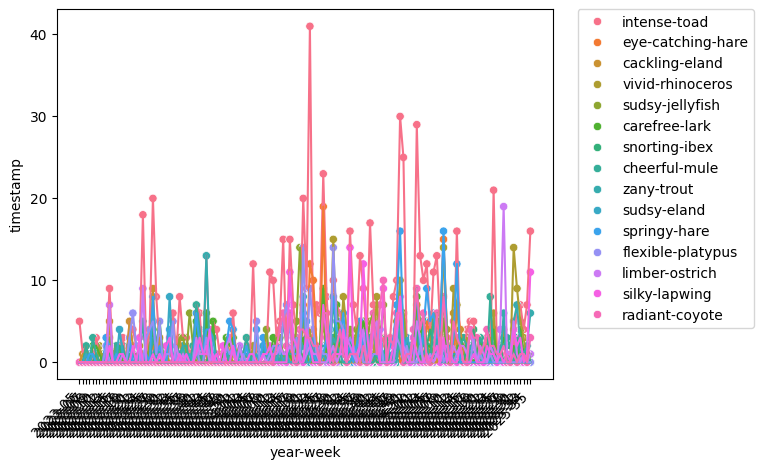

In [13]:
# put legend outside the plot
sns.scatterplot(data=p, x="year-week", y="timestamp", hue="author", legend=True)
sns.lineplot(data=p, x="year-week", y="timestamp", legend=False, hue="author")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xticks(rotation=45, ha="right");

In [14]:
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(["date", "day_of_week"]).size().reset_index(name="message_count")
df_agg

,date,day_of_week,message_count
0,2023-02-01,Wednesday,4
1,2023-02-02,Thursday,3
2,2023-02-03,Friday,4
3,2023-02-08,Wednesday,6
4,2023-02-10,Friday,2
...,...,...,...
567,2025-09-03,Wednesday,1
568,2025-09-04,Thursday,8
569,2025-09-05,Friday,4
570,2025-09-07,Sunday,3


Sometimes, you want to group the timeseries in clusters, eg per day of the week (of per month, or per year, etc).
Facetgrid is a nice way to do this.

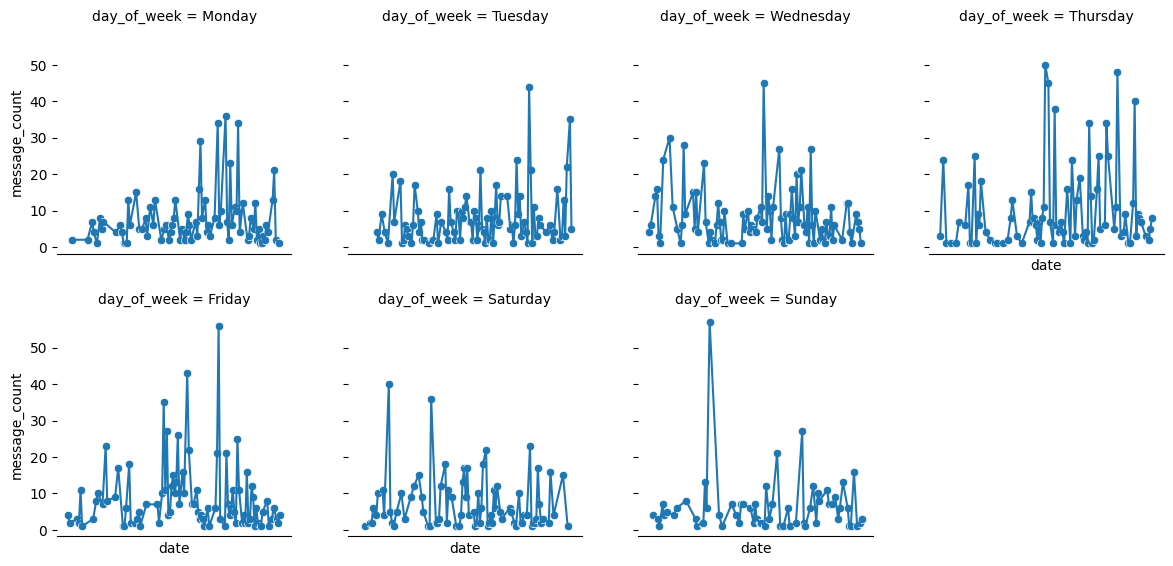

In [15]:
# Set the order of the days of the week
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col="day_of_week", col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, "date", "message_count")
g.map(sns.lineplot, "date", "message_count")
g.set(xticks=[])
g.despine(left=True, bottom=False)

Another nice plot is the area plot. Plotly has a nice version if this one.

In [16]:
import plotly.express as px

# first count the number for every category, for every date
p = df.groupby(["date", "timestamp_category"]).size().reset_index(name="message_count")
# then, make the count cumulative for every category
p["cumulative_count"] = p.groupby("timestamp_category")["message_count"].cumsum()

fig = px.area(
    p,
    x="date",
    y="cumulative_count",
    color="timestamp_category",
    line_group="timestamp_category",
    labels={"cumulative_count": "Cumulative Message Count"},
)
fig.show()

# Code for two authors

I have experimented with two authors, and explored the question "who is the first (or last) of the day to send a message?".
I didnt tweak this for groupchats.

In [17]:
df_grouped = df.groupby("date").agg(
    {
        "timestamp": ["min", "max"],
        "author": ["first", "last"],
    }
)
df_grouped.columns = df_grouped.columns.map("_".join)
df_grouped

,timestamp_min,timestamp_max,author_first,author_last
date,,,,
2023-02-01,2023-02-01 20:46:43+00:00,2023-02-01 20:55:55+00:00,dynamic-frog,dynamic-frog
2023-02-02,2023-02-02 16:59:39+00:00,2023-02-02 17:14:46+00:00,dynamic-frog,dynamic-frog
2023-02-03,2023-02-03 12:45:36+00:00,2023-02-03 18:27:41+00:00,cheerful-boar,soft-eland
2023-02-08,2023-02-08 14:04:13+00:00,2023-02-08 16:43:58+00:00,bouncy-worm,bouncy-worm
2023-02-10,2023-02-10 15:30:14+00:00,2023-02-10 17:13:36+00:00,piebald-rhinoceros,chuckling-stork
...,...,...,...,...
2025-09-03,2025-09-03 07:05:49+00:00,2025-09-03 07:05:49+00:00,zany-trout,zany-trout
2025-09-04,2025-09-04 10:46:02+00:00,2025-09-04 18:01:40+00:00,intense-toad,joyful-okapi
2025-09-05,2025-09-05 06:49:41+00:00,2025-09-05 10:19:00+00:00,zany-trout,waggish-porcupine


In [18]:
df_grouped["timestamp_max_shifted"] = df_grouped["timestamp_max"].shift()

# Calculate the time difference
df_grouped["time_difference"] = (
    df_grouped["timestamp_min"] - df_grouped["timestamp_max_shifted"]
)
df_grouped

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference
date,,,,,,
2023-02-01,2023-02-01 20:46:43+00:00,2023-02-01 20:55:55+00:00,dynamic-frog,dynamic-frog,NaT,NaT
2023-02-02,2023-02-02 16:59:39+00:00,2023-02-02 17:14:46+00:00,dynamic-frog,dynamic-frog,2023-02-01 20:55:55+00:00,0 days 20:03:44
2023-02-03,2023-02-03 12:45:36+00:00,2023-02-03 18:27:41+00:00,cheerful-boar,soft-eland,2023-02-02 17:14:46+00:00,0 days 19:30:50
2023-02-08,2023-02-08 14:04:13+00:00,2023-02-08 16:43:58+00:00,bouncy-worm,bouncy-worm,2023-02-03 18:27:41+00:00,4 days 19:36:32
2023-02-10,2023-02-10 15:30:14+00:00,2023-02-10 17:13:36+00:00,piebald-rhinoceros,chuckling-stork,2023-02-08 16:43:58+00:00,1 days 22:46:16
...,...,...,...,...,...,...
2025-09-03,2025-09-03 07:05:49+00:00,2025-09-03 07:05:49+00:00,zany-trout,zany-trout,2025-09-02 22:13:26+00:00,0 days 08:52:23
2025-09-04,2025-09-04 10:46:02+00:00,2025-09-04 18:01:40+00:00,intense-toad,joyful-okapi,2025-09-03 07:05:49+00:00,1 days 03:40:13
2025-09-05,2025-09-05 06:49:41+00:00,2025-09-05 10:19:00+00:00,zany-trout,waggish-porcupine,2025-09-04 18:01:40+00:00,0 days 12:48:01


In [19]:
mapping = {
    v: ((1 - k) * -1 + (k * 1))
    for k, v in enumerate(df_grouped["author_first"].unique())
}
# this only works with two authors
# mapping = {'author1': 1, 'author2' : -1}
mapping

{'dynamic-frog': -1,
 'cheerful-boar': 1,
 'bouncy-worm': 3,
 'piebald-rhinoceros': 5,
 'vivid-rhinoceros': 7,
 'sudsy-jellyfish': 9,
 'gaudy-whale': 11,
 'zany-trout': 13,
 'coltish-owl': 15,
 'carefree-lark': 17,
 'intense-toad': 19,
 'sparkly-mole': 21,
 'splattered-barracuda': 23,
 'kooky-tapir': 25,
 'mind-blowing-kudu': 27,
 'ebullient-mosquito': 29,
 'silky-lapwing': 31,
 'snorting-ibex': 33,
 'lustrous-reindeer': 35,
 'wispy-reindeer': 37,
 'cheerful-mule': 39,
 'flexible-platypus': 41,
 'cackling-eland': 43,
 'soft-eland': 45,
 'dazzling-yak': 47,
 'limber-ostrich': 49,
 'springy-hare': 51,
 'eye-catching-hare': 53,
 'quick-chamois': 55,
 'chuckling-stork': 57,
 'peppy-rat': 59,
 'peppy-badger': 61,
 'sudsy-eland': 63,
 'cackling-wasp': 65,
 'sudsy-gazelle': 67,
 'waggish-porcupine': 69,
 'stippled-pig': 71,
 'dazzling-curlew': 73,
 'ethereal-lapwing': 75,
 'joyful-salmon': 77,
 'joyful-okapi': 79,
 'multicolored-dogfish': 81,
 'rollicking-ostrich': 83,
 'nimble-raven': 85,
 '

In [20]:
mapping.items()

dict_items([('dynamic-frog', -1), ('cheerful-boar', 1), ('bouncy-worm', 3), ('piebald-rhinoceros', 5), ('vivid-rhinoceros', 7), ('sudsy-jellyfish', 9), ('gaudy-whale', 11), ('zany-trout', 13), ('coltish-owl', 15), ('carefree-lark', 17), ('intense-toad', 19), ('sparkly-mole', 21), ('splattered-barracuda', 23), ('kooky-tapir', 25), ('mind-blowing-kudu', 27), ('ebullient-mosquito', 29), ('silky-lapwing', 31), ('snorting-ibex', 33), ('lustrous-reindeer', 35), ('wispy-reindeer', 37), ('cheerful-mule', 39), ('flexible-platypus', 41), ('cackling-eland', 43), ('soft-eland', 45), ('dazzling-yak', 47), ('limber-ostrich', 49), ('springy-hare', 51), ('eye-catching-hare', 53), ('quick-chamois', 55), ('chuckling-stork', 57), ('peppy-rat', 59), ('peppy-badger', 61), ('sudsy-eland', 63), ('cackling-wasp', 65), ('sudsy-gazelle', 67), ('waggish-porcupine', 69), ('stippled-pig', 71), ('dazzling-curlew', 73), ('ethereal-lapwing', 75), ('joyful-salmon', 77), ('joyful-okapi', 79), ('multicolored-dogfish', 8

In [21]:
df_grouped["last_message"] = df_grouped["author_last"].map(mapping)
df_grouped["first_message"] = df_grouped["author_first"].map(mapping)
df_grouped["last_balance"] = df_grouped["last_message"].cumsum()
df_grouped["first_balance"] = df_grouped["first_message"].cumsum()

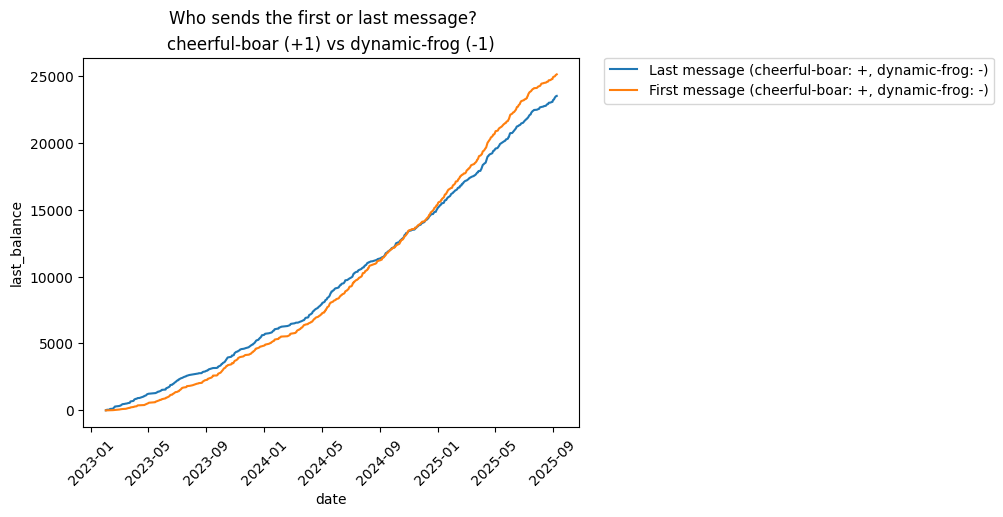

In [22]:
# Get the actual author names from the mapping dictionary
author_positive = [k for k, v in mapping.items() if v == 1][0]
author_negative = [k for k, v in mapping.items() if v == -1][0]

# Create more descriptive labels
sns.lineplot(
    data=df_grouped,
    x="date",
    y="last_balance",
    label=f"Last message ({author_positive}: +, {author_negative}: -)",
)
sns.lineplot(
    data=df_grouped,
    x="date",
    y="first_balance",
    label=f"First message ({author_positive}: +, {author_negative}: -)",
)

# Adjust title to use actual author names
plt.suptitle("Who sends the first or last message?")
plt.xticks(rotation=45)
plt.title(f"{author_positive} (+1) vs {author_negative} (-1)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)

In [23]:
df_grouped.head()

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference,last_message,first_message,last_balance,first_balance
date,,,,,,,,,,
2023-02-01,2023-02-01 20:46:43+00:00,2023-02-01 20:55:55+00:00,dynamic-frog,dynamic-frog,NaT,NaT,-1.0,-1,-1.0,-1
2023-02-02,2023-02-02 16:59:39+00:00,2023-02-02 17:14:46+00:00,dynamic-frog,dynamic-frog,2023-02-01 20:55:55+00:00,0 days 20:03:44,-1.0,-1,-2.0,-2
2023-02-03,2023-02-03 12:45:36+00:00,2023-02-03 18:27:41+00:00,cheerful-boar,soft-eland,2023-02-02 17:14:46+00:00,0 days 19:30:50,45.0,1,43.0,-1
2023-02-08,2023-02-08 14:04:13+00:00,2023-02-08 16:43:58+00:00,bouncy-worm,bouncy-worm,2023-02-03 18:27:41+00:00,4 days 19:36:32,3.0,3,46.0,2
2023-02-10,2023-02-10 15:30:14+00:00,2023-02-10 17:13:36+00:00,piebald-rhinoceros,chuckling-stork,2023-02-08 16:43:58+00:00,1 days 22:46:16,57.0,5,103.0,7


In [24]:
def time_to_decimal(time_obj):
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600


df_grouped["decimal_first_time"] = df_grouped.timestamp_min.apply(time_to_decimal)
df_grouped["decimal_last_time"] = df_grouped.timestamp_max.apply(time_to_decimal)

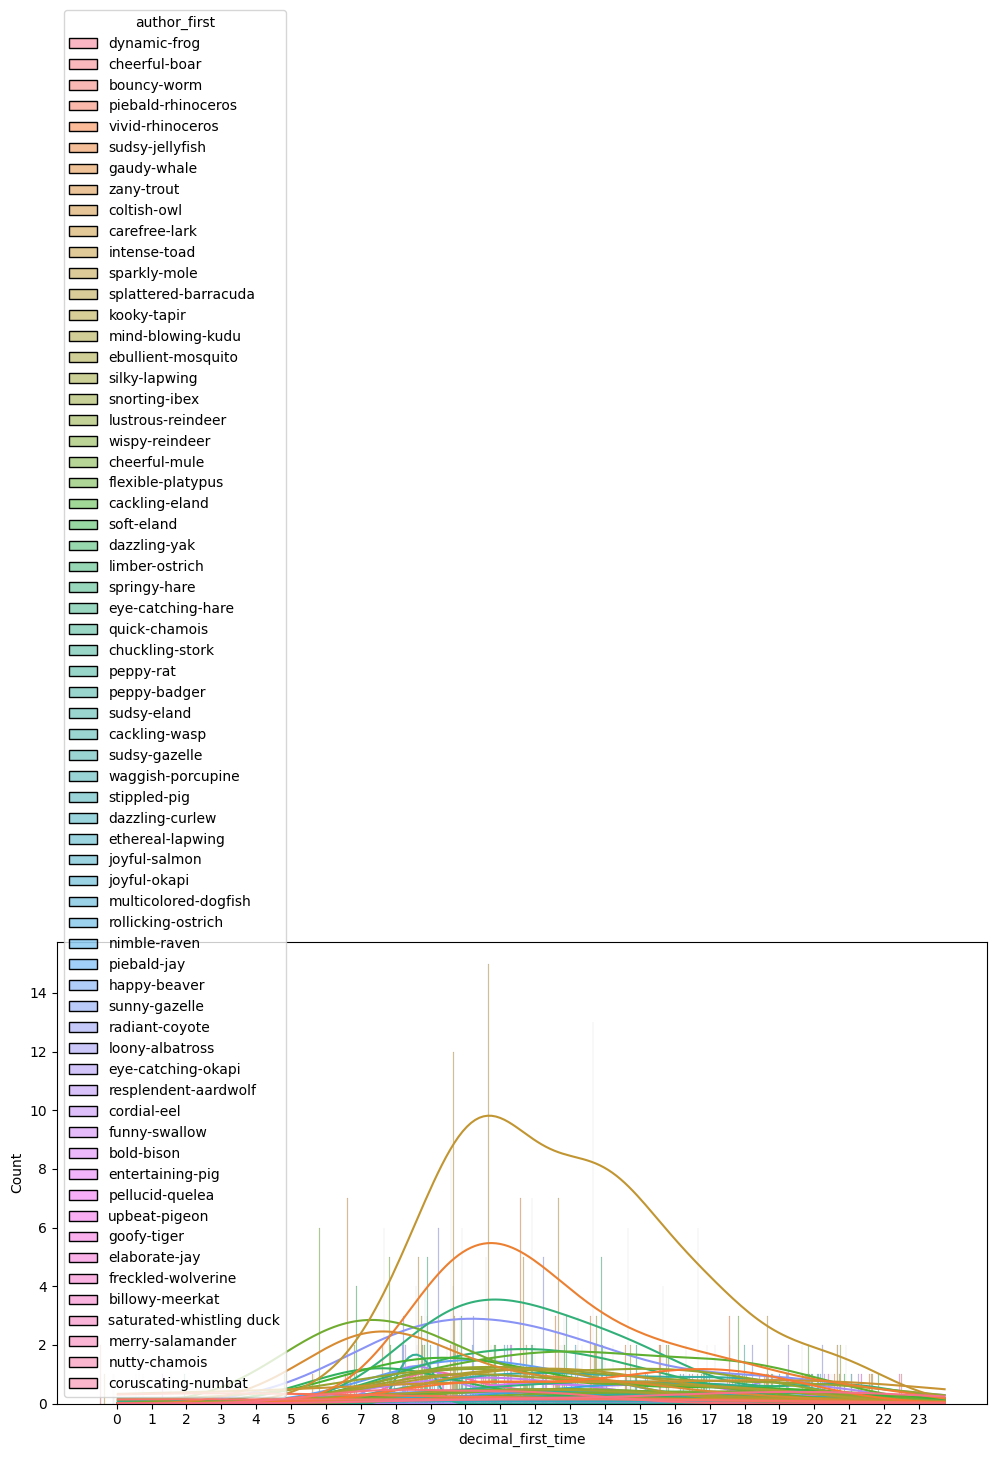

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0, 25)]
sns.histplot(
    data=df_grouped,
    x="decimal_first_time",
    hue="author_first",
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax,
)
ax.set_xticks(range(0, 24));

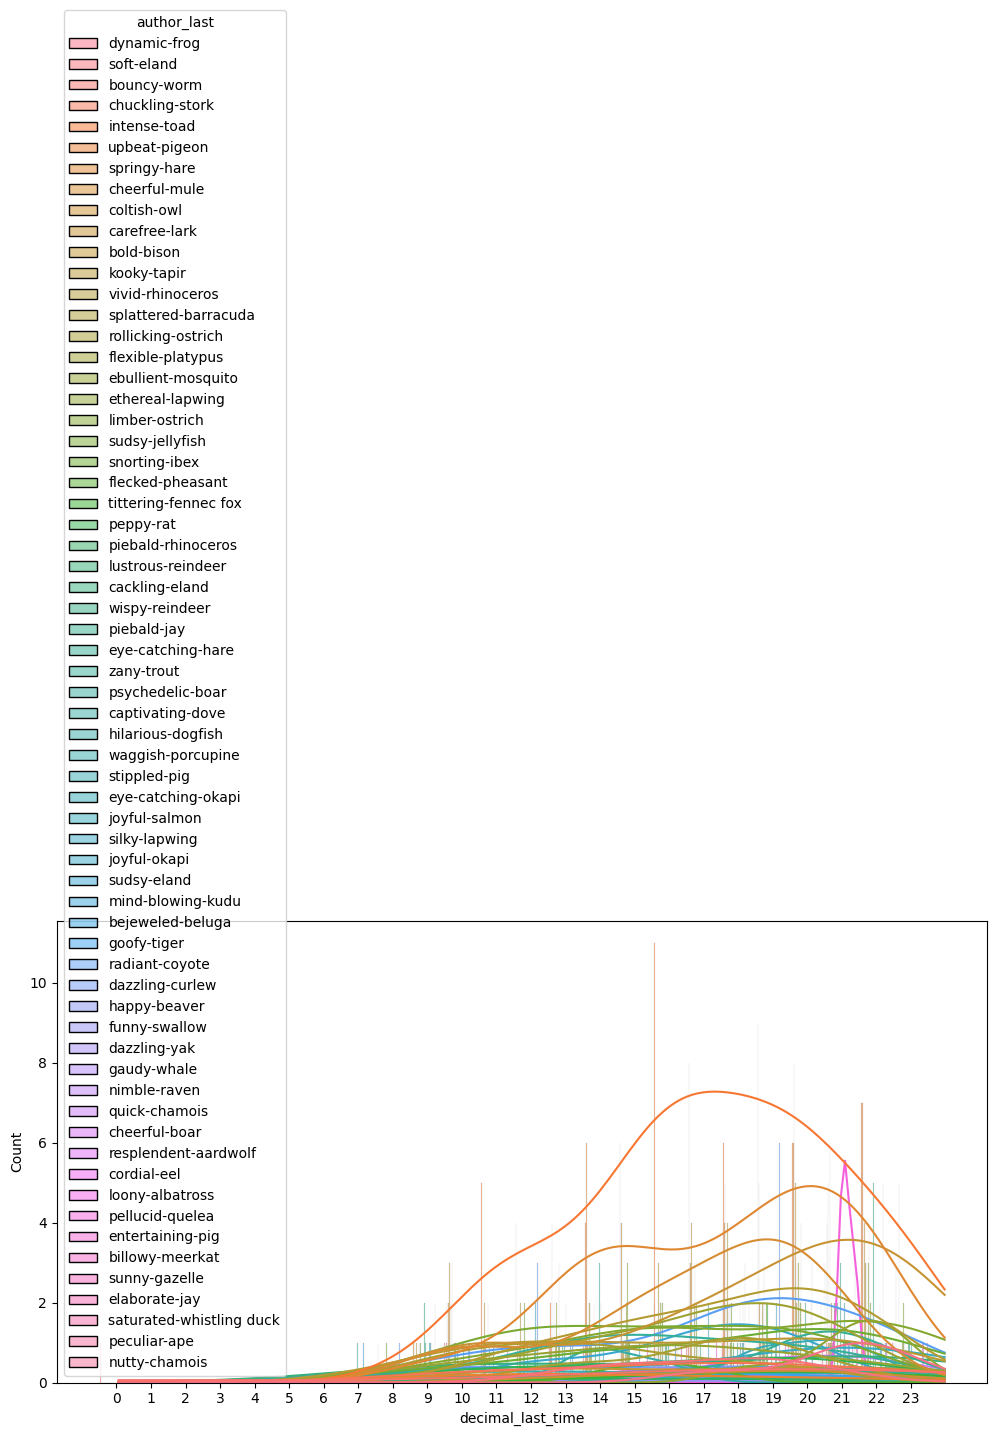

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0, 25)]
sns.histplot(
    data=df_grouped,
    x="decimal_last_time",
    hue="author_last",
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax,
)
ax.set_xticks(range(0, 24));

In [27]:

def decimal_delta(td):
    if td == 0:
        return 0
    return td.total_seconds() / 3600


df["next_author"] = df.author.shift(-1)
df["next_timestamp"] = df.timestamp.shift(-1)
df["reaction_time"] = df.next_timestamp - df.timestamp
df["decimal_reaction_time"] = df.reaction_time.apply(decimal_delta)
df["reply"] = df.apply(lambda x: x.author != x.next_author, axis=1)
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length,date,isoweek,year-week,next_author,next_timestamp,reaction_time,decimal_reaction_time,reply
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,Wednesday,87,2023-02-01,5,2023-05,intense-toad,2023-02-01 20:52:10+00:00,0 days 00:05:27,0.090833,True
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,Wednesday,31,2023-02-01,5,2023-05,intense-toad,2023-02-01 20:52:45+00:00,0 days 00:00:35,0.009722,False
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,Wednesday,40,2023-02-01,5,2023-05,dynamic-frog,2023-02-01 20:55:55+00:00,0 days 00:03:10,0.052778,True
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,Wednesday,19,2023-02-01,5,2023-05,dynamic-frog,2023-02-02 16:59:39+00:00,0 days 20:03:44,20.062222,False
5,2023-02-02 16:59:39+00:00,"Goede middag Herman , Ik heb Ista gebeld hun m...",dynamic-frog,False,False,153,False,worktimes,16:59:39,Thursday,153,2023-02-02,5,2023-05,intense-toad,2023-02-02 17:05:04+00:00,0 days 00:05:25,0.090278,True


Text(0.5, 1.0, 'Who is the fastest in responding?')

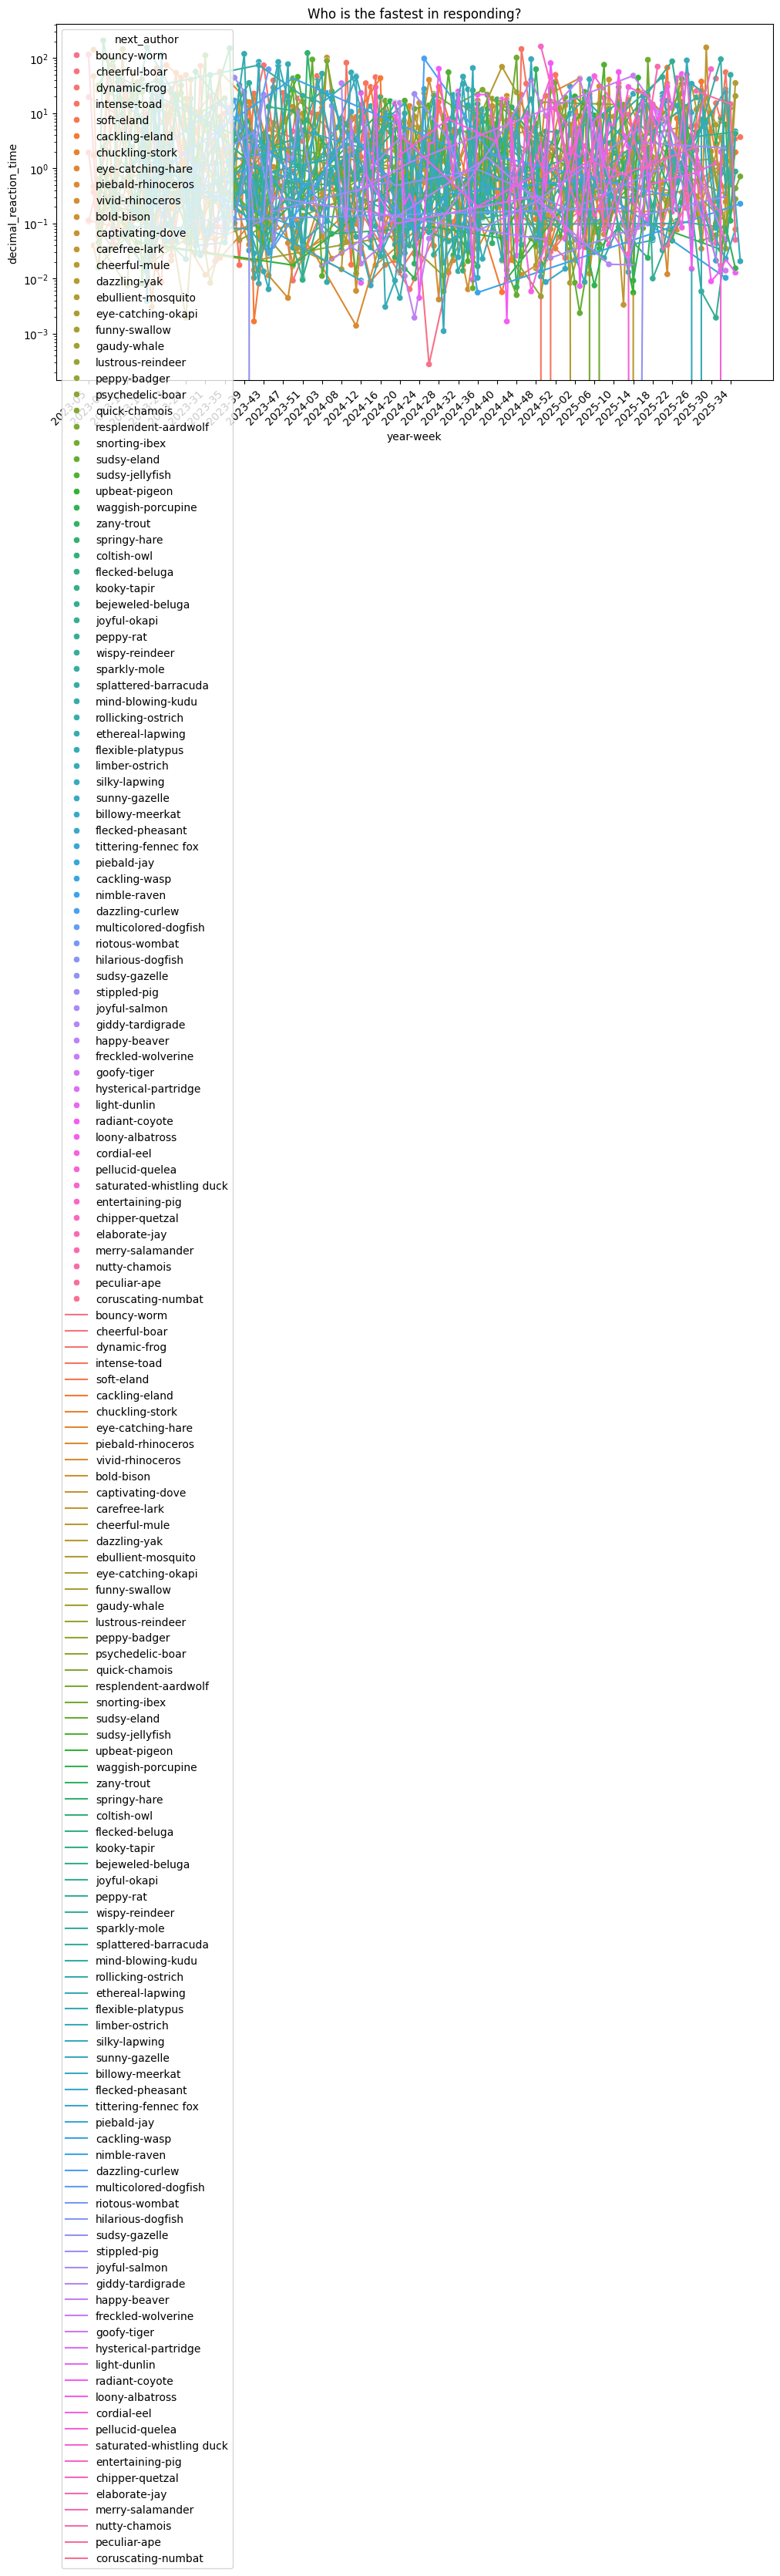

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
p = (
    df[df.reply]
    .groupby(["year-week", "next_author"])
    .agg({"decimal_reaction_time": "mean"})
)
sns.scatterplot(
    data=p, x="year-week", y="decimal_reaction_time", hue="next_author", ax=ax
)
sns.lineplot(data=p, x="year-week", y="decimal_reaction_time", hue="next_author", ax=ax)
plt.yscale("log")
interval = 4
xticks = p.reset_index()["year-week"].unique()[::interval]
# xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha="right")
plt.title("Who is the fastest in responding?")

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_74149/251910427.py:3: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



(0.0, 24.0)

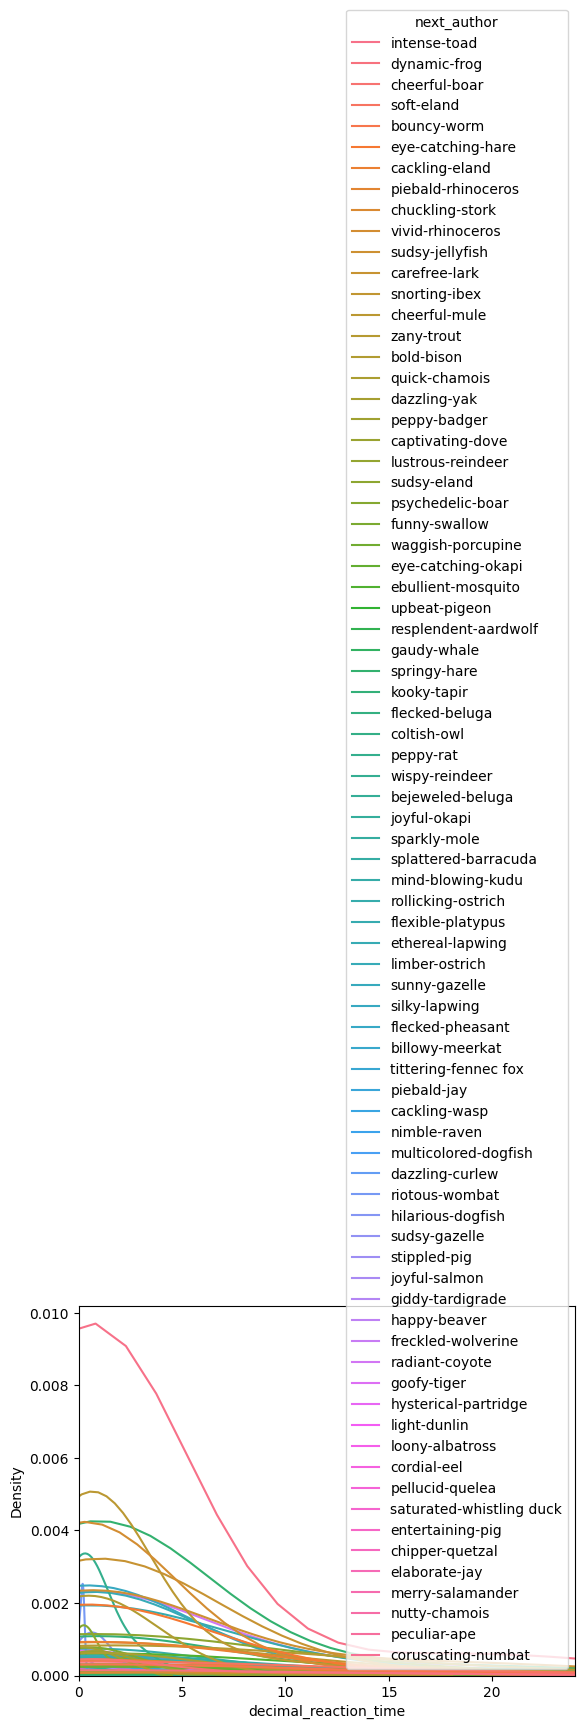

In [29]:
p = df[df.reply]

sns.kdeplot(data=p, x="decimal_reaction_time", hue="next_author")
plt.xlim((0, 24))
# uncomment log if necessary
# plt.yscale('log')